<img src="images/keepcoding.png" width=200 align="left">

# Módulo de Matemáticas 101: reto del fin de semana

El reto de esta semana es implementar el algoritmo de Singular Value Decomposition para comprimir una imagen. Podéis guiaros por lo visto en las clases y os recomiendo también esta web:

https://timbaumann.info/svd-image-compression-demo/

## SVD para comprimir una imagen

El algoritmo de Singular Value Decomposition, del que ya hemos hablado en el módulo, nos puede servir para comprimir una imagen. Vamos a implementar varias funciones para esto. Como repaso, el algoritmo nos devuelve la descomposición de una matriz en tres matrices, una de ellas con los elementos principales y las otras dos con los vectores principales.

Usaremos:

- Una imagen de `scipy.datasets`
- La implementación del algoritmo en `scipy.linalg`: https://docs.scipy.org/doc/scipy-1.14.0/reference/generated/scipy.linalg.svd.html
- La librería `matplotlib`para las gráficas
- El error SSE (sum of squared estimate of errors)


Definición:

$$SSE =  \sum_{i=1}^{n}  (x_{i} -  \widehat{x}_i ) ^2 $$

Donde:

- $x_i$ son los valores de la matriz original X
- $\widehat{x}_i$ son los valores de la matriz reconstruida $\widehat{X}$

Lo primero, vemos la imagen que vamos a comprimir:

In [1]:
!pip install pooch
!pip install scipy

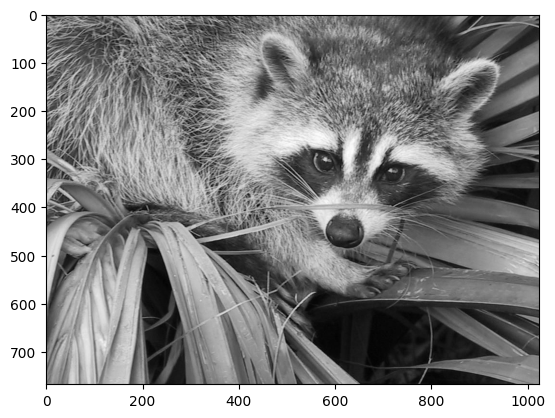

In [2]:
import matplotlib.pyplot as plt
from scipy import datasets
%matplotlib inline

# Load image
A = datasets.face(gray=True)

plt.imshow(A, cmap=plt.cm.gray)

In [3]:
A

array([[114, 130, 145, ..., 119, 129, 137],
       [ 83, 104, 123, ..., 118, 134, 146],
       [ 68,  88, 109, ..., 119, 134, 145],
       ...,
       [ 98, 103, 116, ..., 144, 143, 143],
       [ 94, 104, 120, ..., 143, 142, 142],
       [ 94, 106, 119, ..., 142, 141, 140]], dtype=uint8)

In [4]:
type(A)

numpy.ndarray

In [5]:
A.shape

(768, 1024)

In [6]:
A.max()

250

In [7]:
A.min()

0

Las siguientes funciones te ayudarán a llegar a la solución final:

### 1. Implementa la función para el SSE
La función debe tener como entrada las dos matrices y como salida un número que será el error cometido.

In [8]:
import numpy as np

def sse_score(array_original, array_modified):
    """
    Calculate SSE for 'array_modified' from 'array_original'
    """
    return np.sum((array_original-array_modified)**2)

X = np.array([[1, 2], [3, 4]])
X_hat = np.array([[1.01, 1.75], [2.81, 3.99]])
assert np.isclose(sse_score(X, X_hat),0.0988)

### 2. Implementa una función para ejecutar SVD
La función debe tener como entrada una matriz y como salida las tres matrices de la descomposición.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html

In [9]:
import numpy as np
import scipy

def svd_arrays(array):
    """
    Return arrays from Singular Value Descomposition (SVD) of 'array'.
    Arrays are ready for a reconstruction of the original array
    Singular values vector is converted to diagonal array
    """
    U, s, Vt = scipy.linalg.svd(array, full_matrices = False)
    S = np.diag(s)
    return U, S, Vt # S es una matriz diagonal

X = np.array([[1, 2, 3], [3, 4, 4]])
U, S, Vt = svd_arrays(X)
assert min(X.shape) == min(S.shape)


In [10]:
type(U[0][0])

numpy.float64

### 3. Implementa una función para reconstruir la imagen

Esta función deberá reconstruir la imagen a partir de un set de matrizes (U, S, Vt) dado.

In [11]:
def rebuild_array(U, S, Vt):
    """
    Rebuild array from SVD arrays 'U' , 'S' and 'Vt'
    """
    return U @ S @ Vt

X_hat = rebuild_array(U, S, Vt)
assert X_hat.shape == (U.shape[0],Vt.shape[1])

En este punto, ya puedes ver cuál es el error cometido si se reconstruye la matriz inicial directamente después de aplicar SVD.

In [12]:
sse = sse_score(X, X_hat)
print(f"El error de reconstrucción es: {sse}")

El error de reconstrucción es: 7.543482406175925e-30


### 4. Implementa la compresión

Esta es la parte más complicada. A la función le tendremos que pasar la imagen, en forma matricial, y el número de componentes que queremos usar para la compresión.

La función aplicará SVD y reconstruirá la matriz usando solo los n_comp primeros valores propios de la descomposición. 

532710345


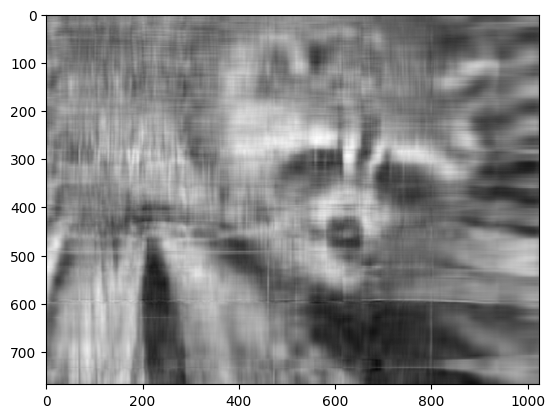

In [64]:
def calculate_channel_compressed(image, n_singular_values):
    """
    Return a compressed version of one channel 'image'
    SVD method is applied and 'n_singular_values' 
    are selected for the compression
    """
    U, S, Vt = svd_arrays(image) # SVD

    n_red = n_singular_values + 1
    S_red = S[:n_red,:n_red] # Reduce size of arrays
    U_red = U[:,:n_red]
    Vt_red = Vt[:n_red,:]
    
    image_compressed = rebuild_array(U_red, S_red, Vt_red) # Rebuild array
    image_compressed = image_compressed.astype(np.int64)
    
    return image_compressed

racoon = datasets.face(gray=True)
racoon_compressed = calculate_channel_compressed(racoon, 10)
print(sse_score(racoon, racoon_compressed))
plt.imshow(racoon_compressed, cmap=plt.cm.gray)

### 5. Gráficas del resultado

Por último, se pide que pruebes para varios valores del número de componentes y grafiques la imagen original junto con varias compresiones. Puedes usar un grid 2x2 de `matplotlib`.

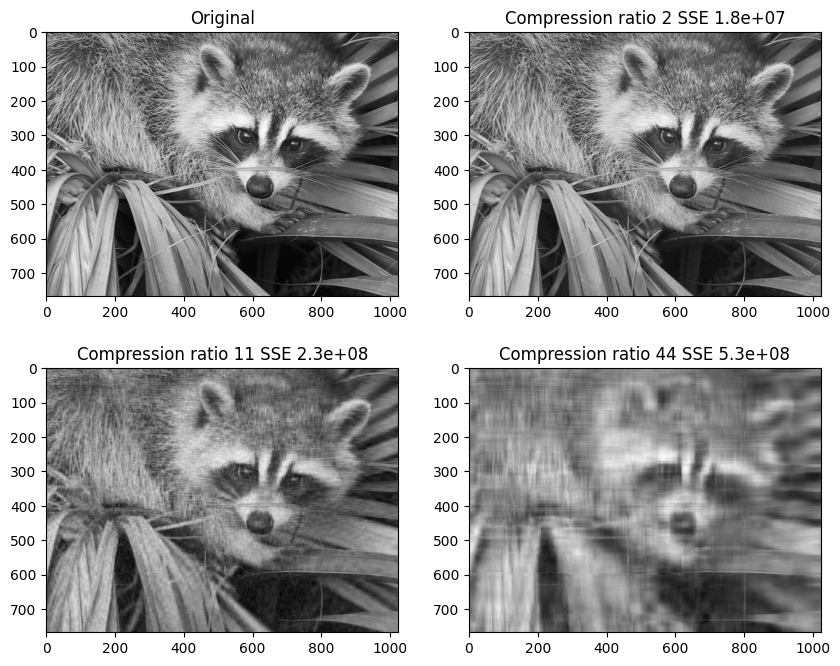

In [40]:
racoon = datasets.face(gray=True)
N_SINGULAR_VALUES_LIST = [200,40,10]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
axs = axs.ravel()

axs[0].imshow(racoon, cmap=plt.cm.gray)
axs[0].set_title("Original")

for index, n_singular_values in zip(range(1,4),N_SINGULAR_VALUES_LIST):
    racoon_compressed = calculate_channel_compressed(racoon, n_singular_values)
    original_size = racoon.shape[0] * racoon.shape[1]
    compress_size = (racoon.shape[0] * n_singular_values) + (racoon.shape[1] * n_singular_values) + n_singular_values
    compression_ratio = original_size/compress_size
    title = f"Compression ratio {round(compression_ratio)} SSE {sse_score(racoon,racoon_compressed):.1e}"
    axs[index].imshow(racoon_compressed, cmap=plt.cm.gray)
    axs[index].set_title(title)


### Versión imagen en color

In [81]:
racoon = datasets.face(gray=False)
racoon.shape
racoon[0,0,:]
racoon[...,1].shape

(768, 1024)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


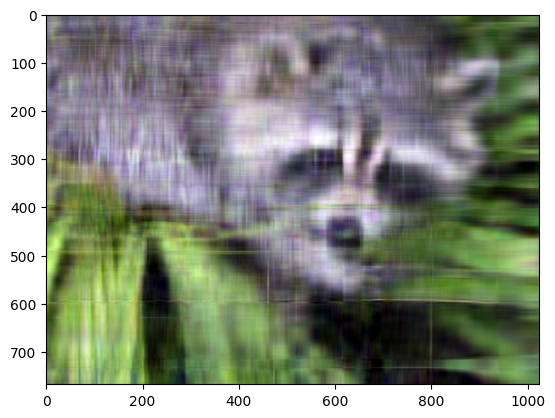

In [148]:
def colapse_rgb_image(channels):
    """
    From list of channels RGB merge into rgb image format array (x,y,3)
    """
    return np.stack(channels,axis=2)

a = np.array([[1,2,3,4],[1,1,1,3]])
b = np.array([[2,3,4,3],[2,2,2,4]])
c = np.array([[5,6,7,1],[3,4,5,1]])

r = np.array([[[1,2,5],[2,3,6],[3,4,7],[4,3,1]],[[1,2,3],[1,2,4],[1,2,5],[3,4,1]]])
assert np.array_equal(colapse_rgb_image([a,b,c]), r)

def calculate_rgb_compressed(image, n_singular_values):
    """
    Return a compressed version of RGB channels 'image'
    """
    list_channels_array = []
    for index in range(0,3):
        channel = image[...,index]
        list_channels_array.append(calculate_channel_compressed(channel, n_singular_values))
        channels_array = np.array(list_channels_array)
        image_compressed = colapse_rgb_image(channels_array)
    return image_compressed
racoon_compressed = calculate_rgb_compressed(racoon, 10)
plt.imshow(racoon_compressed)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


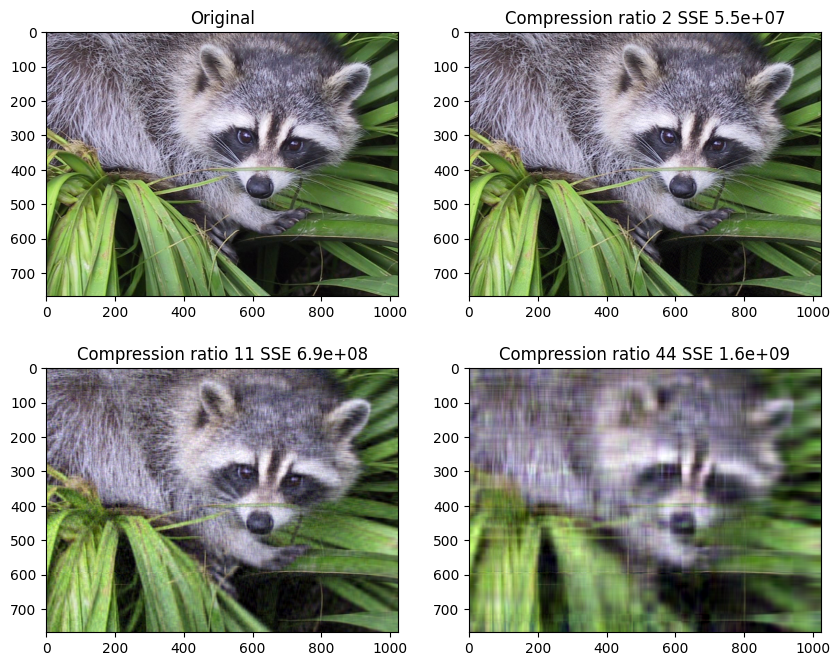

In [149]:
racoon = datasets.face(gray=False)
N_SINGULAR_VALUES_LIST = [200,40,10]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
axs = axs.ravel()

axs[0].imshow(racoon)
axs[0].set_title("Original")

for index, n_singular_values in zip(range(1,4),N_SINGULAR_VALUES_LIST):
    racoon_compressed = calculate_rgb_compressed(racoon, n_singular_values)
    original_size = racoon.shape[0] * racoon.shape[1]
    compress_size = (racoon.shape[0] * n_singular_values) + (racoon.shape[1] * n_singular_values) + n_singular_values
    compression_ratio = original_size/compress_size
    title = f"Compression ratio {round(compression_ratio)} SSE {sse_score(racoon,racoon_compressed):.1e}"
    axs[index].imshow(racoon_compressed)
    axs[index].set_title(title)